# SIR waves velocities

[Index](../0-index.ipynb)

In this notebook, we show that the simulations of the SIR dynamics on a 2d lattice produce a pulled moving front, and show the agreement of the velocity with theoretical predictions.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
import sys
import numpy as np
import cupy as cp
import pandas as pd
import h5py
import datetime
import scipy
import imageio

from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.colors as mco
import matplotlib.gridspec as mgs
import matplotlib.cm as cm
from matplotlib import animation
plt.rcParams['svg.fonttype'] = 'none'

from IPython.display import HTML
from IPython.display import Image

In [3]:
sys.path.append(str(Path('..') / 'code'))

from functions import get_residual_susceptible, lattice_2d_plot_position, lattice_2d_plot_velocities

In [4]:
resdir = Path('../results/')
if not resdir.is_dir():
    raise ValueError('No results directory!')

In [5]:
resfile = resdir / 'lattice_2d_nneighbors.hdf5'
complevel=7
complib='zlib'
# if resfile.is_file():
#     with h5py.File(resfile,'r') as f5py:
#         f5py.visit(print)

## Parameters

In [6]:
N1 = 1024
N2 = 256
pref = "N{:d}_M{:d}".format(N1,N2)
gamma_real = 0.1
istart = int(0.1*N1)     # start plot from this site (avoid boundary effects)

dpi=300
exts = ['.png', '.svg']

In [7]:
gamma_list = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98]
n_list = len(gamma_list)
print(gamma_list)

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98]


In [8]:
times_list = []
S_tot_list = []
I_tot_list = []
Sm_list = []
Im_list = []

for n in range(n_list):
    gamma = gamma_list[n]
    
    # load results
    path = str(Path(pref) / "gamma_{:.2e}".format(gamma))
    with h5py.File(resfile,'r') as f5py:
        if not (path in f5py.keys()):
            raise ValueError("{:s} not in the database".format(path))
        grp = f5py[path]

    #     print(grp.keys())
        name = "times"
        times = grp[name][:]

        name = "susceptible"
        Ss = grp[name][:]

        name = "infected"
        Is = grp[name][:]

    S_tot = np.mean(Ss, axis=(1,2))
    I_tot = np.mean(Is, axis=(1,2))

    if N2 == 1:
        midline = [0]
    else:
        midline = [N2//2-1,N2//2]
    Sm = np.mean(Ss[:,:,midline], axis=2)
    Im = np.mean(Is[:,:,midline], axis=2)
   
    times_list.append(times)
    S_tot_list.append(S_tot)
    I_tot_list.append(I_tot)
    Sm_list.append(Sm)
    Im_list.append(Im)

Compute final state to define position of the front

In [9]:
sinf_list = np.array([get_residual_susceptible(gamma_tilde) for gamma_tilde in gamma_list])
mass_list = 0.5*(sinf_list+1.)

## Figures

In [10]:
figdir = Path('..') / 'figures' / '10-lattice_2d_pulled_wave'
if not figdir.is_dir():
    figdir.mkdir(parents=True, exist_ok=True)
print(figdir)

../figures/10-lattice_2d_pulled_wave


### Waves position

In [11]:
for ext in exts:
    filepath = figdir / ("wave_position" + ext)
    lattice_2d_plot_position(times_list, [Sm[:, istart:] for Sm in Sm_list], mass=0.5*(sinf_list+1.), fileout=filepath)

../figures/10-lattice_2d_pulled_wave/wave_position.png
../figures/10-lattice_2d_pulled_wave/wave_position.svg


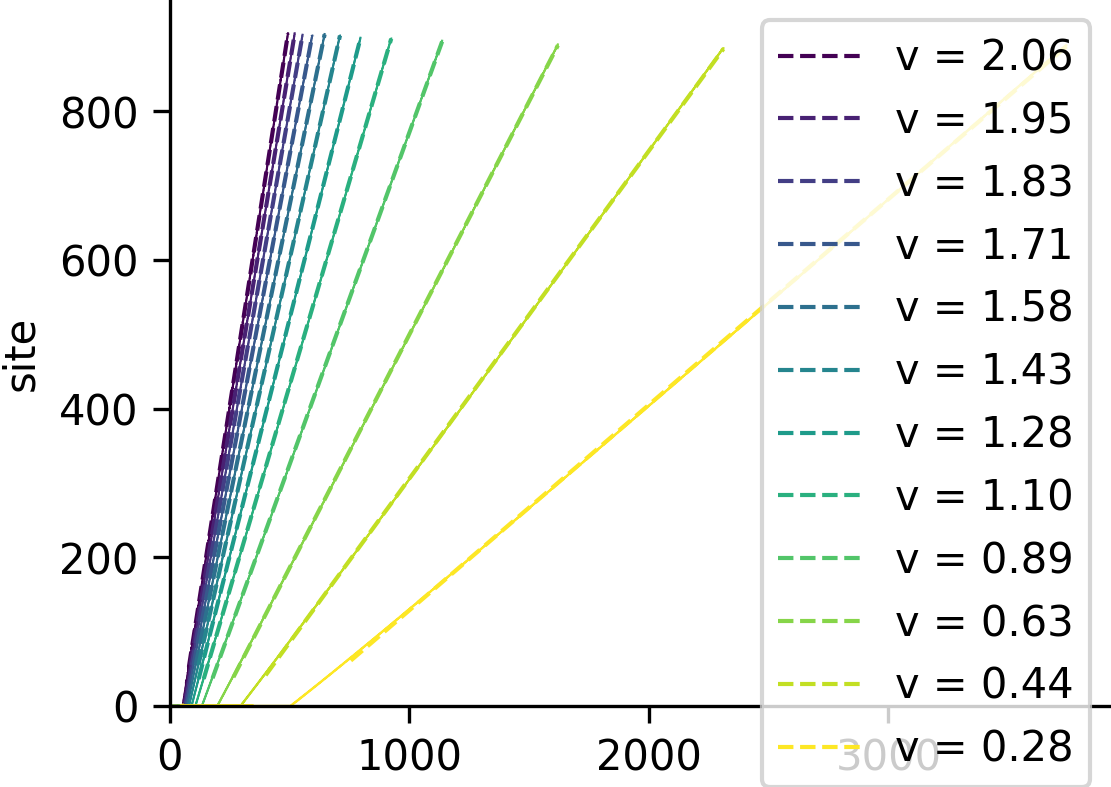

In [12]:
filepath = figdir / ("wave_position" + '.png')
Image(filename=filepath, width=4./3*360)

### Waves velocities

In [13]:
for ext in exts:
    filepath = figdir / ("wave_velocities" + ext)
    lattice_2d_plot_velocities(gamma_list, times_list, [Sm[:, istart:] for Sm in Sm_list], mass=0.5*(sinf_list+1.), fileout=filepath)

../figures/10-lattice_2d_pulled_wave/wave_velocities.png
../figures/10-lattice_2d_pulled_wave/wave_velocities.svg


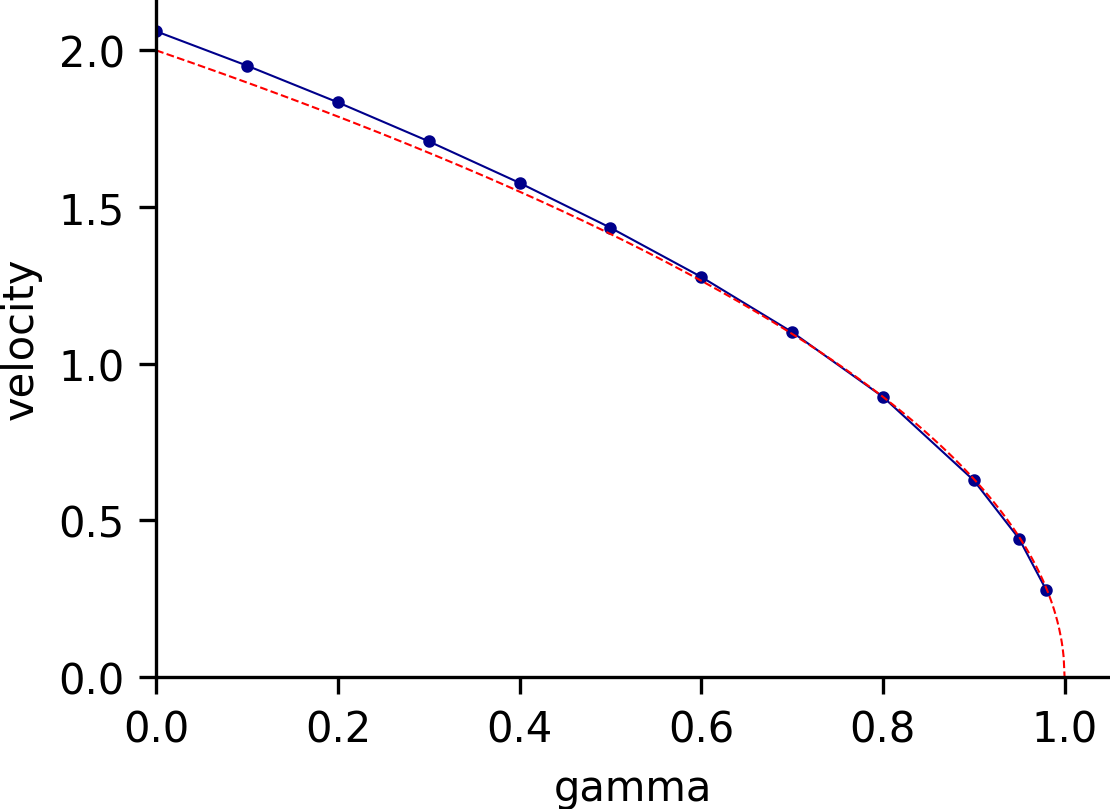

In [14]:
filepath = figdir / ("wave_velocities" + '.png')
Image(filename=filepath, width=4./3*360)